# Milestone Project 2: SkimLit

The purpose of this notebook is to build an NLP model to make reading medical abstracts easier.

The paper we're replicating is avaliable here: [PubMed 200k RCT](https://arxiv.org/abs/1710.06071)

Reading through the paper above, we see that the model architecture that they use to achieve their best results is availbale here: [Neural Networks for Joint Sentence Classification](https://arxiv.org/abs/1612.05251)

## Get data

Since we are replicating the model from the above paper, let's use their data.

[Dataset](https://github.com/Franck-Dernoncourt/pubmed-rct)

In [1]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct
!ls pubmed-rct

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 39, done.
remote: Counting objects: 100% (14/14), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 39 (delta 8), reused 5 (delta 5), pack-reused 25
Receiving objects: 100% (39/39), 177.08 MiB | 14.43 MiB/s, done.
Resolving deltas: 100% (15/15), done.
PubMed_200k_RCT
PubMed_200k_RCT_numbers_replaced_with_at_sign
PubMed_20k_RCT
PubMed_20k_RCT_numbers_replaced_with_at_sign
README.md


In [2]:
# Check what files are in the PubMed20k dataset
!ls pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/

dev.txt   test.txt  train.txt


In [15]:
# Start our experiments using the 20k dataset with numbers replaced by '@' sign
data_dir = '/Users/klsharma22/Desktop/TensorflowCertifcationCourse/Milestone Projects/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/'

In [16]:
# Check all of the filenames in the target directory
import os
filenames = [data_dir + filename for filename in os.listdir(data_dir)]
filenames

['/Users/klsharma22/Desktop/TensorflowCertifcationCourse/Milestone Projects/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt',
 '/Users/klsharma22/Desktop/TensorflowCertifcationCourse/Milestone Projects/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt',
 '/Users/klsharma22/Desktop/TensorflowCertifcationCourse/Milestone Projects/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt']

## Preprocess data

Now we've got some text data, it's time to get one with it.

In [17]:
# Create a function to read the lines of the document
def get_lines(filename):
    '''
    Reads filename and returns the lines of text as a list.

    Args:
        filename (str): Path of filename
    
    Returns:
        A list of string with one string per line from the target filename
    '''

    with open(filename, 'r') as f:
        return f.readlines()

In [19]:
# Let's read in the training lines
train_lines = get_lines(filenames[1])
train_lines[:20]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

Let's think about how we want our data to look

Representation of the data:

```
[{'line_number': 0,
    'target': 'BACKGROUND',
    'text': 'xyz',
    'total_lines': 11}]
```

In [20]:
def preprocess_text_with_line_numbers(filename):
    '''
    Returns a list of dictionary of abstract line data.

    Takes in filename, reads it contents and sorts through each line, extracting things like the target label, the text of the sentence, number of snetences and what sentence number line is.
    '''
    input_lines = get_lines(filename)
    abstract_lines = ""
    abstract_samples = []

    for line in input_lines: # if the line is the id number
        if line.startswith("###"):
            abstract_id = line
            abstract_lines = ""
        elif line.isspace(): # if it is the new line
            abstract_line_split = abstract_lines.splitlines()

            for line_number, abstract_line in enumerate(abstract_line_split):
                line_data = {}
                target_text_split = abstract_line.split('\t')
                line_data['target'] = target_text_split[0]
                line_data['text'] = target_text_split[1].lower()
                line_data['line_number'] = line_number
                line_data['total_lines'] = len(abstract_line_split) - 1
                abstract_samples.append(line_data)

        else: # if it is the text
            abstract_lines += line

    return abstract_samples

In [24]:
train_samples = preprocess_text_with_line_numbers(filenames[1])
val_samples = preprocess_text_with_line_numbers(filenames[0])
test_samples = preprocess_text_with_line_numbers(filenames[2])

len(train_samples), len(val_samples), len(test_samples)

(180040, 30212, 30135)

In [27]:
# Check the first abstract
train_samples[:14]

[{'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'line_number': 0,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'line_number': 1,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'line_number': 2,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'line_number': 3,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'secondary outcome measures included the western ontari

Now that we have our data in the form of dictionary, let's create a dataframe

In [28]:
import pandas as pd
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)

train_df.head()

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11


In [30]:
# Distribution of labels
train_df['target'].value_counts()

target
METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: count, dtype: int64

<Axes: ylabel='Frequency'>

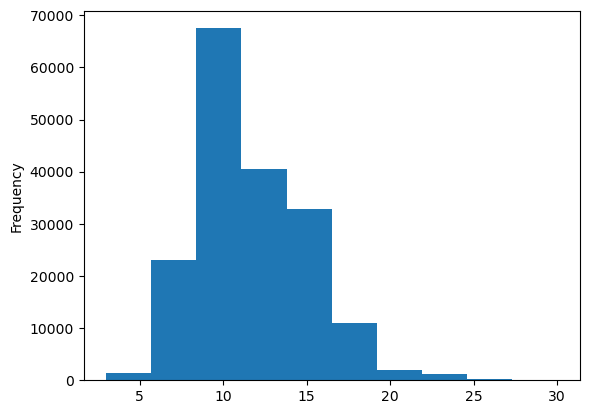

In [31]:
# Let's check length of different lines
train_df['total_lines'].plot.hist()

### Get a lists of sentences

In [32]:
# Convert abstract text lines into lists
train_sentences = train_df['text'].to_list()
val_sentences = val_df['text'].to_list()
test_sentences = test_df['text'].to_list()

len(train_sentences), len(val_sentences), len(test_sentences)

(180040, 30212, 30135)

## Make numeric labels

In [37]:
from sklearn.preprocessing import OneHotEncoder

one_hot_encoder = OneHotEncoder(sparse= False)
train_labels_one_hot = one_hot_encoder.fit_transform(train_df['target'].to_numpy().reshape(-1, 1))
val_labels_one_hot = one_hot_encoder.transform(val_df['target'].to_numpy().reshape(-1, 1))
test_labels_one_hot = one_hot_encoder.transform(test_df['target'].to_numpy().reshape(-1, 1))

len(train_labels_one_hot), len(val_labels_one_hot), len(test_labels_one_hot)

/Users/klsharma22/miniconda3/envs/ml/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


(180040, 30212, 30135)

## Label encode labels

In [38]:
# Extract labels and encode them into integers
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()

train_labels_encoded = label_encoder.fit_transform(train_df['target'].to_numpy())
val_labels_encoded = label_encoder.transform(val_df['target'].to_numpy())
test_labels_encoded = label_encoder.transform(test_df['target'].to_numpy())

train_labels_encoded

array([3, 2, 2, ..., 4, 1, 1])

In [39]:
# get class names and number of classes from LabelEncoder
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_

num_classes, class_names

(5,
 array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

## Experiments

### Model 0: Getting a baseling

In [40]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# Create a pipeline

model_0 = Pipeline([
    ('tf-idf', TfidfVectorizer()),
    ('clf', MultinomialNB())
])

# Fit the pipeline to the training data
model_0.fit(X= train_sentences,
            y= train_labels_encoded)

Pipeline(steps=[('tf-idf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [41]:
# Evaluate baseline model on validation dataset
model_0.score(X= val_sentences,
              y= val_labels_encoded)

0.7218323844829869

In [42]:
# Make prediction using baseline model
baseline_preds = model_0.predict(val_sentences)
baseline_preds

array([4, 1, 3, ..., 4, 4, 1])

#### Download helper function script for evaluation

!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

In [44]:
from helper_functions import calculate_results

In [46]:
# Calculate baseline results
baseline_results = calculate_results(y_true= val_labels_encoded,
                                     y_pred= baseline_preds)
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

In [47]:
import tensorflow as tf

## Preparing our data for deep sequence models

Before we start building deep model, we've got tocreate vectorization and embedding layers

In [48]:
import numpy as np
from tensorflow.keras import layers

In [49]:
# how long is ech sentences on average
sent_lens = [len(sentence.split()) for sentence in train_sentences]
avg_sentence_len = np.mean(sent_lens)
avg_sentence_len

26.338269273494777

(array([1.6499e+04, 5.6664e+04, 5.2683e+04, 2.9050e+04, 1.3111e+04,
        5.6610e+03, 3.0490e+03, 1.5190e+03, 8.0800e+02, 4.3200e+02,
        2.2600e+02, 1.2800e+02, 7.7000e+01, 3.9000e+01, 3.0000e+01,
        1.5000e+01, 9.0000e+00, 8.0000e+00, 4.0000e+00, 8.0000e+00,
        7.0000e+00, 5.0000e+00, 1.0000e+00, 2.0000e+00, 3.0000e+00,
        0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([  1.        ,  10.83333333,  20.66666667,  30.5       ,
         40.33333333,  50.16666667,  60.        ,  69.83333333,
         79.66666667,  89.5       ,  99.33333333, 109.16666667,
        119.        , 128.83333333, 138.66666667, 148.5       ,
        158.33333333, 168.16666667, 178.        , 187.83333333,
        197.66666667, 207.5       , 217.33333333, 227.16666667,
        237.        , 246.83333333, 256.66666667, 266.5       ,
        276.33333333, 286.16666667, 296.        ]),
 <BarContainer object of 30 artists>)

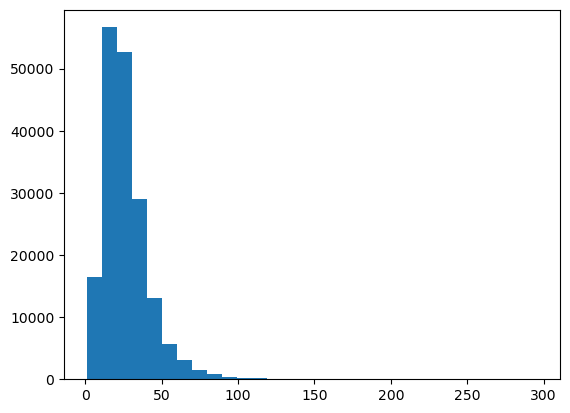

In [53]:
# What is the distribution of the sentences
import matplotlib.pyplot as plt
plt.hist(sent_lens, bins= 30)

In [54]:
# How longof a sentence length covers 95% of examples
output_seq_len = int(np.percentile(sent_lens, 95))
output_seq_len

55

In [55]:
# maximum sequence length
max(sent_lens)

296

### Create text vectorizzer layer

We want to make a layer which converts text data into vectors

In [59]:
# Creating text vectorizer
max_vocab = 68000
text_vectorizer = layers.TextVectorization(max_tokens= max_vocab,
                                           output_sequence_length= output_seq_len)

In [60]:
# Adapt text vectorizer to training sentences
text_vectorizer.adapt(train_sentences)

In [68]:
# Test out text vectorizer on random sentences

import random
target_senteces = random.choice(train_sentences)
print(f"Text: {target_senteces}")
print(f"Length of Text: {len(target_senteces.split())}")
print(f"Vectorized: {text_vectorizer(target_senteces)}")

Text: a recently developed alternative method is the so-called patch repair , in this approach a mesh can be placed intraperitoneally through open surgery .
Length of Text: 24
Vectorized: [    8  1612   481   775   363    20     2 12959  2022   958     5    23
   453     8  2173   171    36  1768 30618   313   655   115     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0]


In [69]:
# How many words in our training vocab
rct_20k_vocab = text_vectorizer.get_vocabulary()

print(f"Number of words in vocab: {len(rct_20k_vocab)}")
print(f"Most common words: {rct_20k_vocab[:5]}")
print(f"Least common words: {rct_20k_vocab[-5:]}")

Number of words in vocab: 64841
Most common words: ['', '[UNK]', 'the', 'and', 'of']
Least common words: ['aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']


In [70]:
# Get the config of our text vectorizer
text_vectorizer.get_config()

{'name': 'text_vectorization_1',
 'trainable': True,
 'dtype': 'string',
 'batch_input_shape': (None,),
 'max_tokens': 68000,
 'standardize': 'lower_and_strip_punctuation',
 'split': 'whitespace',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': False,
 'sparse': False,
 'ragged': False,
 'vocabulary': None,
 'idf_weights': None,
 'encoding': 'utf-8',
 'vocabulary_size': 64841}

### Create an embedding layer

In [83]:
embedding = layers.Embedding(input_dim= len(rct_20k_vocab),
                             output_dim= 128,
                             mask_zero= True, # use masking to handle variable sequence length
                             name= 'token_embedding'
                             )

In [94]:
random_sentence = random.choice(train_sentences)
print(f"Text: {random_sentence}")
print(f"Embed: {embedding(text_vectorizer([random_sentence])).shape}")

Text: fifty-two patients with heart failure , persistent af , left ventricular ( lv ) ejection fraction < @ % , and left bundle branch block underwent cardiac resynchronization therapy ( crt ) + avn ablation , and were randomized to one of the following groups : ( @ ) atrial rhythm control ( arc ) ; ( @ ) af .
Embed: (1, 55, 128)
